# This is a test for extraction of radiomics features from the patients

In [32]:
import radiomics
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets
import SimpleITK as sitk
import logging
import pandas as pd
import json

from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, featureextractor, getFeatureClasses

In [33]:
# Get the PyRadiomics logger (default log-level = INFO)
logger = radiomics.logger
logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

# Write out all log entries to a file
handler = logging.FileHandler(filename='../testLog.txt', mode='w')
formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [49]:
folder_path = "../study"

Parameters for radiomcis feature extracion

In [50]:
params = folder_path + "/static_files/radiomics_params.yaml"

## Print some slices of patient 2

In [51]:
subj = "VNSLC_04"
subj_path = "%s/subjects/%s" % (folder_path, subj)
subj_path_freesurf = "%s/freesurfer/%s" % (folder_path, subj)

# image_path = "%s/registration/%s_T1_brain_reg.nii.gz" % (subj_path, subj)
# mask_path = "%s/registration/aparc+aseg_reg.mgz" % (subj_path)

image_path = "%s/dMRI/microstructure/dti/%s_FA.nii.gz" % (subj_path, subj)
mask_path = "%s/dlabel/diff/aparc+aseg+thalnuc.bbr.nii.gz" % (subj_path_freesurf)

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# I didnt get this passage but it works
image = sitk.GetImageFromArray(sitk.GetArrayFromImage(image))
mask = sitk.GetImageFromArray(sitk.GetArrayFromImage(mask))

In [74]:
# bb, correctedMask = imageoperations.checkMask(image, mask, label=10)
# if correctedMask is not None:
#     mask = correctedMask
# croppedImage, croppedMask = imageoperations.cropToTumorMask(image, mask, bb)
# 
# plt.imshow(sitk.GetArrayFromImage(croppedImage)[10, :, :], cmap="gray")
# plt.imshow(np.where(sitk.GetArrayFromImage(croppedMask)[10, :, :] == 10, 1, 0), alpha=0.5)
# plt.show()

In [75]:
print(image[60, 60, 30])

0.8405095338821411


## Load on pyRadiomics


In [52]:
extractor = featureextractor.RadiomicsFeatureExtractor(params)

# extractor.enableAllImageTypes()
# extractor.enableAllFeatures()

# ----- Test the mean, standard deviaton, skewness and kurtosis
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=['Mean', 'StandardDeviation', 'Skewness', 'Kurtosis'])

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

INFO:radiomics.featureextractor:Loading parameter file ../study/static_files/radiomics_params.yaml
DEBUG:radiomics.featureextractor:Parameters parsed, input is valid.
DEBUG:radiomics.featureextractor:Applying settings
DEBUG:radiomics.featureextractor:Enabled image types: {'Original': {}}
DEBUG:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}
DEBUG:radiomics.featureextractor:Settings: {'interpolator': 'sitkNearestNeighbor', 'minimumROIDimensions': 3, 'weightingNorm': 'euclidean'}
DEBUG:radiomics.featureextractor:Disabling all feature classes
DEBUG:radiomics.featureextractor:Updating enabled features with {'firstorder': ['Mean', 'StandardDeviation', 'Skewness', 'Kurtosis']}
DEBUG:radiomics.featureextractor:Enabled features: {'firstorder': ['Mean', 'StandardDeviation', 'Skewness', 'Kurtosis']}


Extraction parameters:
	 {'minimumROIDimensions': 3, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkNearestNeighbor', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'weightingNorm': 'euclidean'}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': ['Mean', 'StandardDeviation', 'Skewness', 'Kurtosis']}


In [77]:
featureClasses = getFeatureClasses()
print('Active features:')
for cls, features in extractor.enabledFeatures.items():
    if len(features) == 0:
        features = [f for f, deprecated in featureClasses[cls].getFeatureNames().items() if not deprecated]
    for f in features:
        print(f)
        print(getattr(featureClasses[cls], 'get%sFeatureValue' % f).__doc__)

Active features:
Mean

    **8. Mean**

    .. math::
      \textit{mean} = \frac{1}{N_p}\displaystyle\sum^{N_p}_{i=1}{\textbf{X}(i)}

    The average gray level intensity within the ROI.
    
StandardDeviation

    **15. Standard Deviation**

    .. math::
      \textit{standard deviation} = \sqrt{\frac{1}{N_p}\sum^{N_p}_{i=1}{(\textbf{X}(i)-\bar{X})^2}}

    Standard Deviation measures the amount of variation or dispersion from the Mean Value. By definition,
    :math:`\textit{standard deviation} = \sqrt{\textit{variance}}`

    .. note::
      As this feature is correlated with variance, it is marked so it is not enabled by default.
      To include this feature in the extraction, specify it by name in the enabled features
      (i.e. this feature will not be enabled if no individual features are specified (enabling 'all' features),
      but will be enabled when individual features are specified, including this feature).
      Not present in IBSI feature definitions (correlated wit

In [53]:
result = extractor.execute(image, mask, label=13)

INFO:radiomics.featureextractor:Starting voxel based extraction
INFO:radiomics.featureextractor:Calculating features with label: 13
DEBUG:radiomics.featureextractor:Enabled images types: {'Original': {}}
DEBUG:radiomics.featureextractor:Enabled features: {'firstorder': ['Mean', 'StandardDeviation', 'Skewness', 'Kurtosis']}
DEBUG:radiomics.featureextractor:Current settings: {'minimumROIDimensions': 3, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkNearestNeighbor', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 13, 'additionalInfo': True, 'weightingNorm': 'euclidean', 'voxelBased': True}
INFO:radiomics.featureextractor:Loading image and mask
DEBUG:radiomics.imageoperations:Force casting mask to UInt32 to ensure correct datatype.
DEBUG:radiomics.imageoperations:Checking mask with label 13
DEBUG:radiomics.imageoperat

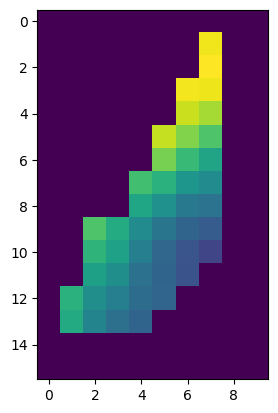

In [70]:
a = sitk.GetArrayFromImage(result["original_firstorder_Mean"])

plt.imshow(a[5, :, :])


## Comparison with the metrics compute with nibabel, numpy and scipy

In [45]:
image = nib.load(image_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

mask = np.where(mask == 13, 1, 0) # Take only the thalamus

In [46]:
assert image.shape == mask.shape

v = image.ravel()
w = mask.ravel()

assert v.size == w.size

# Mean
print("Mean", np.average(v, weights=w))
# Standard Deviation
dstat = DescrStatsW(v, w)
print("Std", dstat.std)
# Skewness
w_discrete = np.round(w).astype(int)
repeat = np.repeat(v, w_discrete)
print("Skewness", stats.skew(repeat, bias=True))
# Kurtosis
print("Kurtosis", stats.kurtosis(repeat, fisher=False, bias=True))


Mean 0.5063262347925882
Std 0.2388446199979036
Skewness 0.09805681068698882
Kurtosis 1.6332679206647815


# Managing the ROI from tracts

In [7]:
from dipy.io.streamline import load_tractogram, save_trk

trk_path = "%s/dpath/acomm_avg16_syn_bbr/path.pd.trk" % subj_path_freesurf
#trk_path = "%s/dMRI/tractography/left-antThalRadiation.trk" % subj_path

trk = load_tractogram(trk_path, "same")
trk.to_vox()
trk.to_corner()

out_path = "../prova.trk"
save_trk(trk, out_path)

from unravel.stream import smooth_streamlines
# if the tract comes from MRtrix3 the smoothing is useless ... (only loose time)
for _ in range(2):
    smooth_streamlines(out_path, out_path)


In [42]:
from dipy.io.streamline import load_tractogram, save_trk, save_tractogram
from unravel.core import tract_to_streamlines, compute_subsegments
from unravel.utils import get_streamline_density, get_streamline_count
from unravel.stream import get_roi_sections_from_nodes
from dipy.io.stateful_tractogram import Space, StatefulTractogram, Origin

wm_path = "%s/dlabel/diff/White-Matter++.bbr.nii.gz" % subj_path_freesurf
wm = nib.load(wm_path).get_fdata()
notWM = wm == 0

trk_path = "../prova.trk"
subsegment = 10

trk = load_tractogram(trk_path, "same")
trk.to_vox()
trk.to_corner()

density = get_streamline_density(trk, subsegment=1) # The density

# Find the density for each streamline
sList = tract_to_streamlines(trk)
totDensityTract = np.zeros(len(sList))

for j, streamline in enumerate(sList):
    # Create a new tract with a single streamline
    # temp_trk = StatefulTractogram([streamline], trk, Space.VOX, origin=Origin.TRACKVIS)
    temp_trk = StatefulTractogram.from_sft([streamline], trk)
    # Get the ROI of the streamline
    roi = get_streamline_density(temp_trk, subsegment=1)
    temp_lenght = np.sum(roi)

    temp_lenght -= np.sum(roi[notWM]) # Correggo la lunghezza escludendo i voxel che vengono esclusi dalla regione, perche non appartenenti alla WM
    roi[notWM] = 0 # rimuovo voxels non appartenenti alla wm
    # Compute the density of the streamline
    totDensityTract[j] = np.sum(density[roi>0])/temp_lenght

# bestTracts_idx = np.argsort(totDensityTract)[::-1][0:1]
bestTracts_idx = np.argsort(totDensityTract)[::-1][0:int(0.01*get_streamline_count(trk))]

streamlines = []
for i in bestTracts_idx:
    streamlines.append(sList[i])

# temp_trk = StatefulTractogram(streamlines, trk, Space.VOX, origin=Origin.TRACKVIS)
temp_trk = StatefulTractogram.from_sft(streamlines, trk)
roi = get_streamline_density(temp_trk)
density[roi==0] = 0

save_tractogram(temp_trk, "../prova1.trk")
nib.save(nib.Nifti1Image(density, temp_trk.affine), "../prova.nii.gz")

In [44]:
import os

def highestProbTractsDensity(trk, wm: None):
    '''
    This function is a modified version of get_streamline_density() from the library RAVEL by Delinte Nicolas.
    The function is also a semplified version, it doesn't take the paramiters for the resolution_increase and the color.
    
    Paramiters
    ----------
    trk : tractogram
        Content of a .trk file

    Returns
    -------

    '''
    density = get_streamline_density(trk, subsegment=1) # The density
    isWM = wm > 0 
    notWM = wm == 0

    # Find the density for each streamline
    sList = tract_to_streamlines(trk)
    totDensityTract = np.zeros(len(sList))

    for j, streamline in enumerate(sList):
        # Create a new tract with a single streamline
        temp_trk = StatefulTractogram.from_sft([streamline], trk)
        # Get the ROI of the streamline
        roi = get_streamline_density(temp_trk, subsegment=1)

        # Se WM mask esiste => Solo i tratti che hanno una probabilità maggiore nella wm vengono considerati

        if wm is None:
            temp_lenght = np.sum(roi) # Normalizzo per la lunghezza del tratto, sennò i tratti più lunghi sarebbero avvantaggiati rispetto a quelli corti.
        else:
            temp_lenght = np.sum(roi[isWM]) # Correggo la lunghezza escludendo i voxel che vengono esclusi dalla regione, perche non appartenenti alla WM
            roi[notWM] = 0 # rimuovo voxels non appartenenti alla wm

        # Compute the density of the streamline
        totDensityTract[j] = np.sum(density[roi>0])/temp_lenght

    bestTracts_idx = np.argsort(totDensityTract)[::-1][0:int(0.01*get_streamline_count(trk))]

    streamlines = []
    for i in bestTracts_idx:
        streamlines.append(sList[i])

    temp_trk = StatefulTractogram.from_sft(streamlines, trk)
    roi = get_streamline_density(temp_trk, subsegment=1)
    density[roi==0] = 0
    if wm is not None:
        density[notWM] = 0

    return density

def correctWeightsTract(weights, thresh=0.1):
    def resize_and_fix_origin(kernel, size):
        """Pads a kernel to reach shape `size`, and shift it in order to cancel phase.
        This is based on the assumption that the kernel is centered in image space.
        A note about this is provided in section 1.4. 
        """
        # Very specific routine... You don't have to understand it
        pad0, pad1, pad2 = size[0]-kernel.shape[0], size[1]-kernel.shape[1], size[2]-kernel.shape[2]
        # shift less if kernel is even, to start with 2 central items
        shift0, shift1, shift2 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2, (kernel.shape[2]-1)//2

        kernel = np.pad(kernel, ((0,pad0), (0,pad1), (0,pad2)), mode='constant')
        kernel = np.roll(kernel, (-shift0, -shift1, -shift2), axis=(0,1,2))
        return kernel

    from scipy import signal
    kernel = [[[1/4, 1/2, 1/4],
               [1/2, 1, 1/2],
               [1/4, 1/2, 1/4]],
              [[1/2, 1, 1/2],
               [1,   4, 1],
               [1/2, 1, 1/2]],
              [[1/4, 1/2, 1/4],
               [1/2, 1, 1/2],
               [1/4, 1/2, 1/4]]]
    kernel = np.array(kernel)

    ftImage = np.fft.fftn(weights)
    ftKernel = np.fft.fftn(resize_and_fix_origin(kernel, weights.shape))
    c = np.real(np.fft.ifftn(ftImage * ftKernel))
    # c = signal.convolve(weights, kernel, mode="same", method="direct")

    c_scal = (c - c.min())/(c.max() - c.min())
    c[c_scal<thresh] = 0
    c[weights == 0] = 0 # because during the convolution are chosen also voxels that are not from the bundle, so we keep only the streamlines of the tract

    return c

dpath = "%s/dpath" % subj_path_freesurf

wm_path = "%s/dlabel/diff/White-Matter++.bbr.nii.gz" % subj_path_freesurf
wm = nib.load(wm_path).get_fdata()

all_densities = []
idx_trk = []

for entry in os.listdir(dpath):
    entry_path = os.path.join(dpath, entry)
    if os.path.isdir(entry_path):
        trk_name = entry.split("_")[0]
        trk_path = os.path.join(entry_path, "path.pd.trk")
        
        trk = load_tractogram(trk_path, "same")
        trk.to_vox()
        trk.to_corner()

        # Get the density filtered by the higest prob streamlines
        idx_trk.append(trk_name)
        all_densities.append(correctWeightsTract(highestProbTractsDensity(trk, wm)))
        


In [132]:
nib.save(nib.Nifti1Image(all_densities[0], trk.affine), f"../{idx_trk[0]}.nii.gz")

In [162]:
tract_path = "%s/dMRI/tractography" % subj_path

idx_ROIpaths = []
densities = []
k = 0

for entry in os.listdir(tract_path):
    entry_path = os.path.join(tract_path, entry)
    if( os.path.isfile(entry_path) and 
        entry_path.endswith(".trk") and 
        not "rmvd" in entry_path ):

        trk_name = entry.split(".")[0]
        density_out_path = os.path.join(subj_path,"masks",f"{subj}_{trk_name}_tract.nii.gz")

        trk = load_tractogram(trk_path, "same")
        trk.to_vox()
        trk.to_corner()

        # Get the binary density filtered by the higest prob streamlines and with corrected weights
        idx_ROIpaths.append(trk_name)
        density = correctWeightsTract(highestProbTractsDensity(trk, wm))
        density = np.where(density>0, 1, 0).astype("int32")
        densities.append(density)

        nib.save(nib.Nifti1Image(densities[k], trk.affine), f"../{idx_ROIpaths[k]}.nii.gz")
        k +=1


In [205]:
def getDictionaryFromLUT(lut_path):
    d = {}
    with open(lut_path, 'r') as file:
        for line in file.readlines():
            fields = line.split()
            if len(fields) == 0 or fields[0].startswith("#"):
                continue
            d[int(fields[0])] = fields[1]
    return d

colorLUT = os.getenv('FREESURFER_HOME') + "/FreeSurferColorLUT.txt"
dict_idx_ROI = getDictionaryFromLUT(colorLUT)

In [206]:
dict_idx_ROI[10]

'Left-Thalamus'

# Conda yml to pip

In [72]:
import ruamel.yaml

yaml = ruamel.yaml.YAML()
data = yaml.load(open('../env.yml'))

requirements = []
for dep in data['dependencies']:
    if isinstance(dep, str):
        package, package_version, python_version = dep.split('=')
        if python_version == '0':
            continue
        requirements.append(package + '==' + package_version)
    elif isinstance(dep, dict):
        for preq in dep.get('pip', []):
            requirements.append(preq)

with open('../requirements.txt', 'w') as fp:
    for requirement in requirements:
       print(requirement, file=fp)